# Models

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import os
import ipaddress
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random

### Chargement des données

On charge les données et on encode les variable catégorielles, on modifie les labels de sortie pour avoir 'none' et 'malveillant'

In [3]:
df0=pd.read_csv("../data/final/Credential_Access.csv")
df1=pd.read_csv("../data/final/Defense_Evasion.csv")
df2=pd.read_csv("../data/final/Discovery.csv")
df3=pd.read_csv("../data/final/Exfiltration.csv")
df4=pd.read_csv("../data/final/Initial_Access.csv")
df5=pd.read_csv("../data/final/none.csv")
df6=pd.read_csv("../data/final/Persistence.csv")
df7=pd.read_csv("../data/final/Privilege_Escalation.csv")
df8=pd.read_csv("../data/final/Reconnaissance.csv")
listeDatasets=[df0,df1,df2,df3,df4,df5,df6,df7,df8]

categorical_columns = ['conn_state', 'protocol', 'service', 'history', 'label_tactic']
  
#Gestion des dates
for i in range(len(listeDatasets)):
    df=listeDatasets[i]

     # Modifier la colonne
    df['label_tactic'] = df['label_tactic'].apply(lambda x: "malveillant" if x != "none" else x)
    
    df['ts'] = pd.to_datetime(df['ts'], unit='s')
    
    df['year'] = df['ts'].dt.year
    df['month'] = df['ts'].dt.month
    df['day'] = df['ts'].dt.day
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['seconde'] = df['ts'].dt.second
    
    df['dayofweek'] = df['ts'].dt.dayofweek  # 0=lundi, 6=dimanche
    
    # Caractéristiques cycliques pour l'heure (pour préserver la nature cyclique)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Caractéristiques cycliques pour le jour de la semaine
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)

    # Trier par timestamp pour calculer les différences temporelles
    df = df.sort_values('ts')
    df['time_since_last'] = df['ts'].diff().dt.total_seconds()

    # Remplacer la première valeur NaN par 0 ou une autre valeur appropriée
    df['time_since_last'] = df['time_since_last'].fillna(0)

    df=df.drop(['ts'], axis=1)
    df=df.drop(['year'], axis=1)
    df=df.drop(['month'], axis=1)
    df=df.drop(['day'], axis=1)
    df=df.drop(['hour'], axis=1)
    df=df.drop(['minute'], axis=1)
    df=df.drop(['seconde'], axis=1)

    #Gestion des adresses IP
    df['src_ip'] = df['src_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    df['dest_ip'] = df['dest_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    
    #Une IPV6 est un trop grand nombre, on ne peut pas le mettre en entier
    #On normalise donc les ip en divisant par la plus grande valeur possible (pour etre entre 0 et 1)
    df['src_ip'] = df['src_ip']/(2**128 - 1) # 2^128 est le max pour IPv6 car codée sur 128 bits
    df['dest_ip'] = df['dest_ip']/(2**128 - 1)

    df['src_ip']=df['src_ip'].astype(float)
    df['dest_ip']=df['dest_ip'].astype(float)

    listeDatasets[i]=df

#Diviser chaque dataset en train/test (85/15)
list_inconnu=['conn_state','protocol','history']
list_df_datasets=[]
compteur=0
for df in listeDatasets:
    train_df, test_inconnu_df = train_test_split(df, test_size=0.15, random_state=42)
    # Convertir en tableau NumPy pour accélérer les modifications
    data_array = test_inconnu_df[list_inconnu].values  # Extraire les colonnes à modifier
    num_rows, num_cols = data_array.shape

    # Générer un masque pour sélectionner aléatoirement 1, 2 ou 3 colonnes par ligne
    for i in range(num_rows):
        compteur += 1
        if compteur % 10000 == 0:  # Affiche seulement toutes les 10 000 lignes pour ne pas ralentir
            print(f"Lignes traitées : {compteur}")

        # Sélectionner aléatoirement des colonnes à modifier
        num_cols_to_modify = random.choice([1, 2, 3])
        cols_to_change = random.sample(range(num_cols), num_cols_to_modify)

        # Modifier directement les valeurs
        for col in cols_to_change:
            data_array[i, col] = 'unknown'

    # Remettre les données modifiées dans le DataFrame
    test_inconnu_df[list_inconnu] = data_array

    # Ajouter à la liste sans refaire de concaténation inutile
    list_df_datasets.append(pd.concat([train_df, test_inconnu_df], ignore_index=True))

# Remplacer listeDatasets en une seule opération
listeDatasets = list_df_datasets

# Créer et stocker les encodeurs
encoders = {}
for col in categorical_columns:
    # Collecter toutes les valeurs uniques de TOUS les datasets
    all_values = pd.concat([df[col] for df in listeDatasets]).unique()
    
    # Créer et ajuster l'encodeur sur toutes les valeurs possibles
    encoders[col] = LabelEncoder().fit(all_values)
    
    # Appliquer l'encodeur à chaque dataset
    for df in listeDatasets:
        df[col] = encoders[col].transform(df[col])


Lignes traitées : 10000
Lignes traitées : 20000
Lignes traitées : 30000
Lignes traitées : 40000
Lignes traitées : 50000
Lignes traitées : 60000
Lignes traitées : 70000
Lignes traitées : 80000
Lignes traitées : 90000
Lignes traitées : 100000
Lignes traitées : 110000
Lignes traitées : 120000
Lignes traitées : 130000
Lignes traitées : 140000
Lignes traitées : 150000
Lignes traitées : 160000
Lignes traitées : 170000
Lignes traitées : 180000
Lignes traitées : 190000
Lignes traitées : 200000
Lignes traitées : 210000
Lignes traitées : 220000
Lignes traitées : 230000
Lignes traitées : 240000
Lignes traitées : 250000
Lignes traitées : 260000
Lignes traitées : 270000
Lignes traitées : 280000
Lignes traitées : 290000
Lignes traitées : 300000
Lignes traitées : 310000
Lignes traitées : 320000


Affichage de la structure d'un dataset encodé

In [4]:
print(listeDatasets[1].columns)
print(listeDatasets[7]["dest_ip"].head())

Index(['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history', 'src_ip', 'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_ip', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'label_tactic', 'dayofweek',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'time_since_last'],
      dtype='object')
0    7.067402e-30
1    7.067396e-30
2    7.067404e-30
3    7.067396e-30
4    7.067402e-30
Name: dest_ip, dtype: float64


### Separation des données

In [5]:
#Diviser chaque dataset en train/test (80/20)
train_dfs = []
test_dfs = []

for df in listeDatasets:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dfs.append(train_df)
    test_dfs.append(test_df)

#Concaténer les ensembles
combined_train = pd.concat(train_dfs)
combined_test = pd.concat(test_dfs)

print(combined_test.head())
print(combined_test.shape)
print(combined_train.columns)

       conn_state  duration  local_orig  local_resp  protocol  service  \
6735            6  0.022819           0           0         1       18   
15280           6  0.733703           0           0         1       18   
28665           6  0.838346           0           0         1       18   
38545           9  0.036003           0           0         3       18   
6434            6  1.442142           0           0         1       18   

       history        src_ip  src_port  orig_bytes  ...  resp_pkts  \
6735        29  7.067404e-30     44147       686.0  ...         48   
15280       29  7.067395e-30     37217      1046.0  ...         68   
28665       29  7.067399e-30     39683      1005.0  ...         68   
38545       61  7.067395e-30     42281       686.0  ...         48   
6434        29  7.067396e-30     36289      1047.0  ...         68   

       resp_ip_bytes  missed_bytes  label_tactic  dayofweek  hour_sin  \
6735           47844             0             0          5 -

### Entrainement du modèle

In [6]:
features = ['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history',  'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'time_since_last']

#On retire les features temporelles, et les IP

label='label_tactic'


# Préparer X et y
X_train = combined_train[features]
y_train = combined_train[label]
X_test = combined_test[features]
y_test = combined_test[label]


# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Création et entraînement du modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Nombre d'arbres
    max_depth=None,  # Profondeur maximale des arbres (None = illimité)
    random_state=42,
    n_jobs=-1  # Utilise tous les cœurs disponibles
)

rf_model.fit(X_train, y_train_encoded)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

print("Modèle Random Forest entraîné avec succès !")


Modèle Random Forest entraîné avec succès !


### Affichage d'un arbre

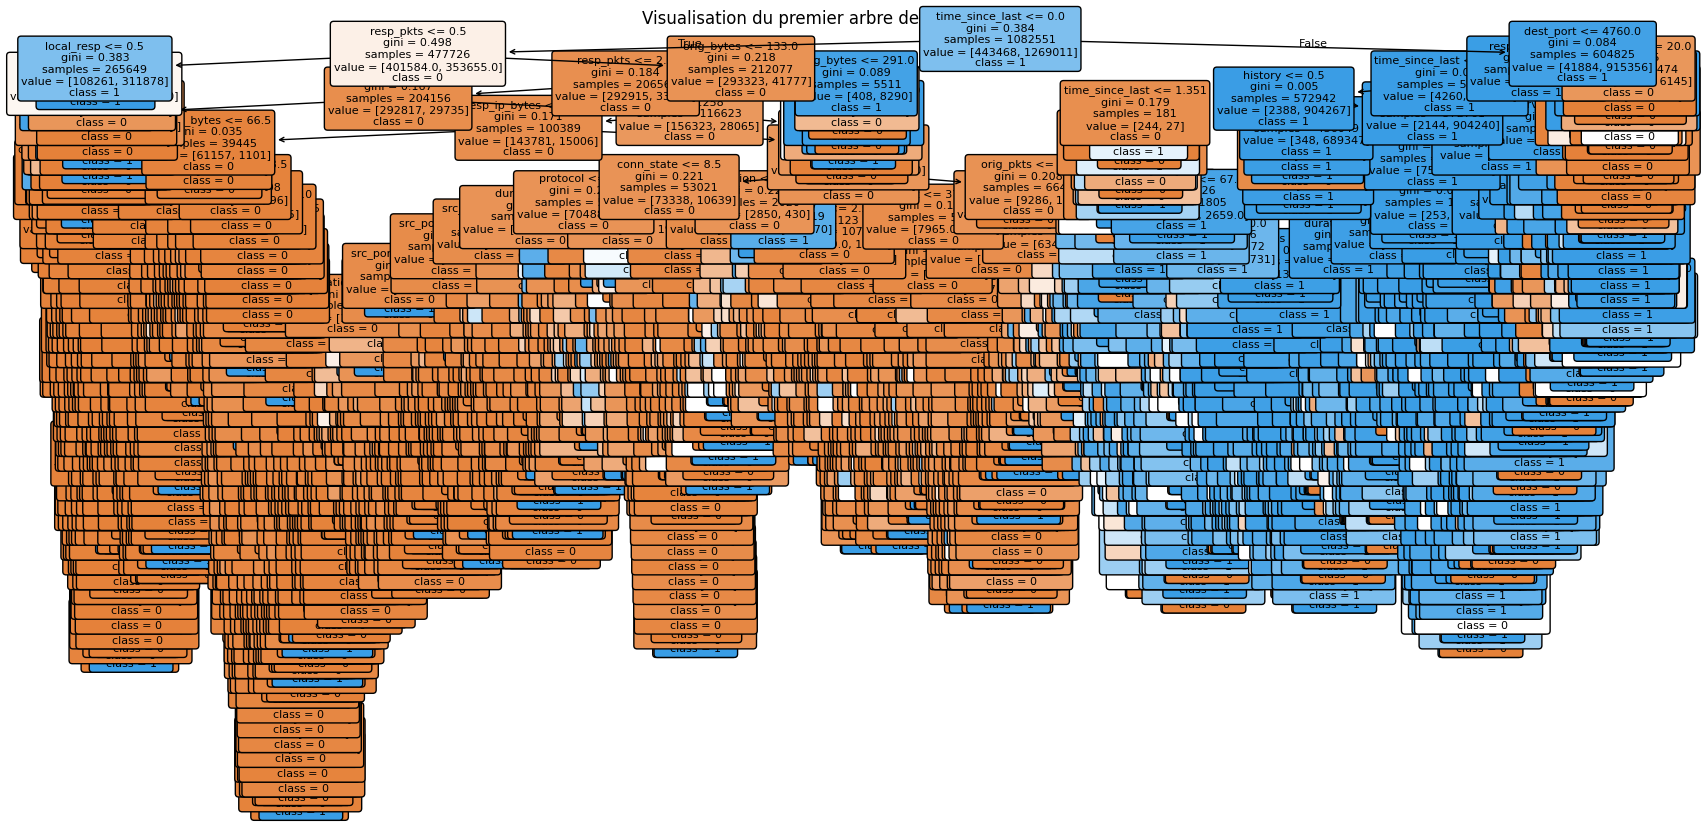

In [7]:
# Sélectionner le premier arbre de la forêt
first_tree = rf_model.estimators_[0]  # Le premier arbre

# Vérifier et convertir les noms des features en chaînes
feature_names_str = [str(f) for f in features]

# Vérifier et convertir les noms des classes en chaînes
class_names_str = [str(c) for c in label_encoder.classes_]

# Afficher l'arbre
plt.figure(figsize=(20, 10))
plot_tree(first_tree, 
          feature_names=feature_names_str,  # Noms des features corrigés
          class_names=class_names_str,  # Noms des classes corrigés
          filled=True,  # Colorer les noeuds
          rounded=True,  # Bords arrondis pour lisibilité
          fontsize=8)

plt.title("Visualisation du premier arbre de la Random Forest")
plt.show()

### Evaluation du modèle

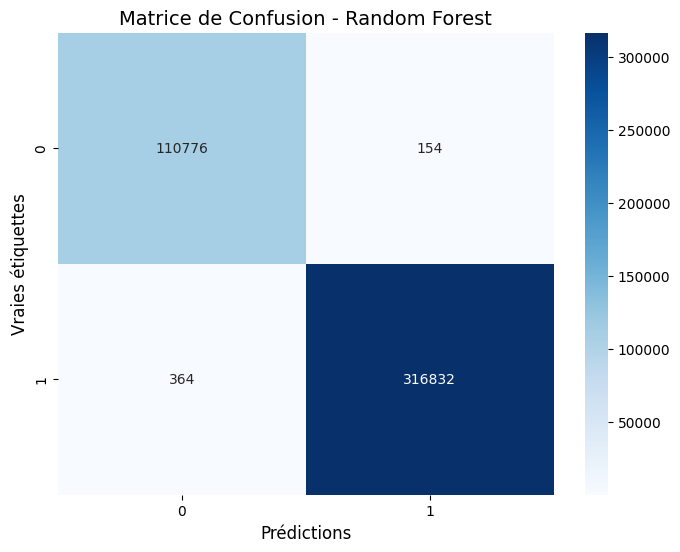


Rapport de classification - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110930
           1       1.00      1.00      1.00    317196

    accuracy                           1.00    428126
   macro avg       1.00      1.00      1.00    428126
weighted avg       1.00      1.00      1.00    428126

Modèle Random Forest sauvegardé !


In [ ]:
# Prédictions avec le modèle Random Forest
y_pred_rf = rf_model.predict(X_test)

# Reconvertir en labels textuels pour l'évaluation
y_pred_labels_rf = label_encoder.inverse_transform(y_pred_rf)
y_test_labels_rf = label_encoder.inverse_transform(y_test_encoded)

# Matrice de confusion
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf)
labels = np.unique(y_test_labels_rf)

# Affichage sous forme de heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Prédictions', fontsize=12)
ax.set_ylabel('Vraies étiquettes', fontsize=12)
ax.set_title('Matrice de Confusion - Random Forest', fontsize=14)
plt.show()

# Rapport de classification
print("\nRapport de classification - Random Forest:")
print(classification_report(y_test_labels_rf, y_pred_labels_rf))

# Sauvegarde du modèle Random Forest
model_rf_package = {
    'model': rf_model,
    'encoders': encoders,
    'features': features
}

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model_rf_package, f)

print("Modèle Random Forest sauvegardé !")



Feature Importance (LightGBM)
- Montre quelles features influencent le plus les prédictions.

C:\Users\loulo\AppData\Local\Temp\ipykernel_28212\2945479931.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_indices][:top_n], y=np.array(features)[sorted_indices][:top_n], palette="viridis")


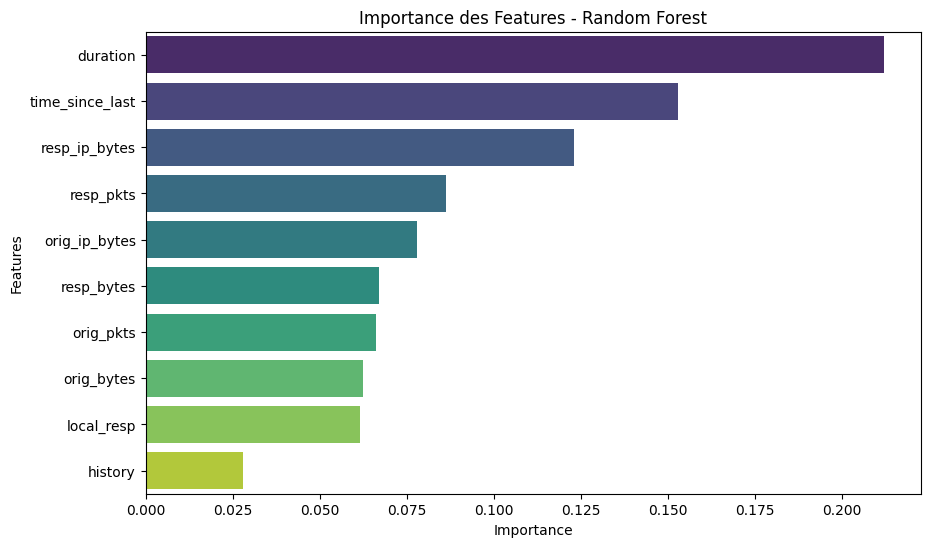

In [ ]:

# Extraire l'importance des features
feature_importances = rf_model.feature_importances_

# Trier les features par importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Tri décroissant
top_n = 10  # Nombre de features à afficher

# Affichage du graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices][:top_n], y=np.array(features)[sorted_indices][:top_n], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Importance des Features - Random Forest")
plt.show()

Matrice de Corrélation
- Permet de voir les relations entre les variables (certaines peuvent être redondantes).
- Utile pour identifier les features qui influencent fortement le modèle.

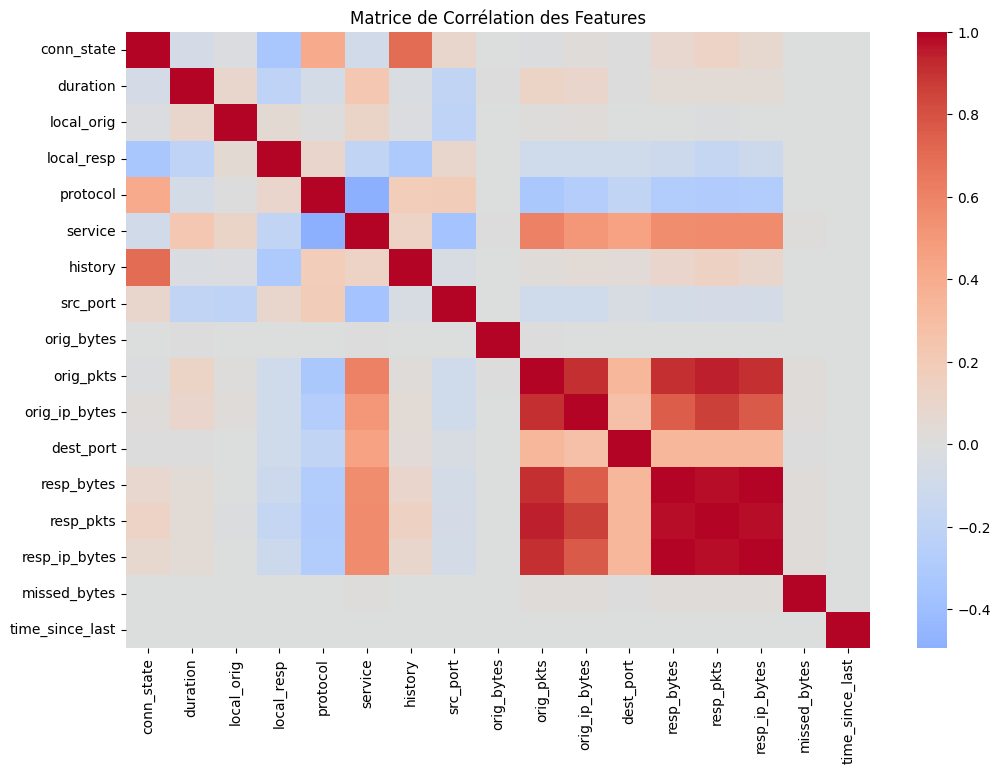

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Matrice de Corrélation des Features")
plt.show()

Score AUC-ROC

In [ ]:
from sklearn.metrics import roc_auc_score


y_pred_proba = gbm.predict(X_test)[:, 1]  # Probabilité de la classe positive (malveillant)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("AUC-ROC Score :", auc_roc)


AUC-ROC Score : 0.9995596242031134
